In [1]:
import cv2

img=cv2.imread('Sandia mini SAR image.jpg')

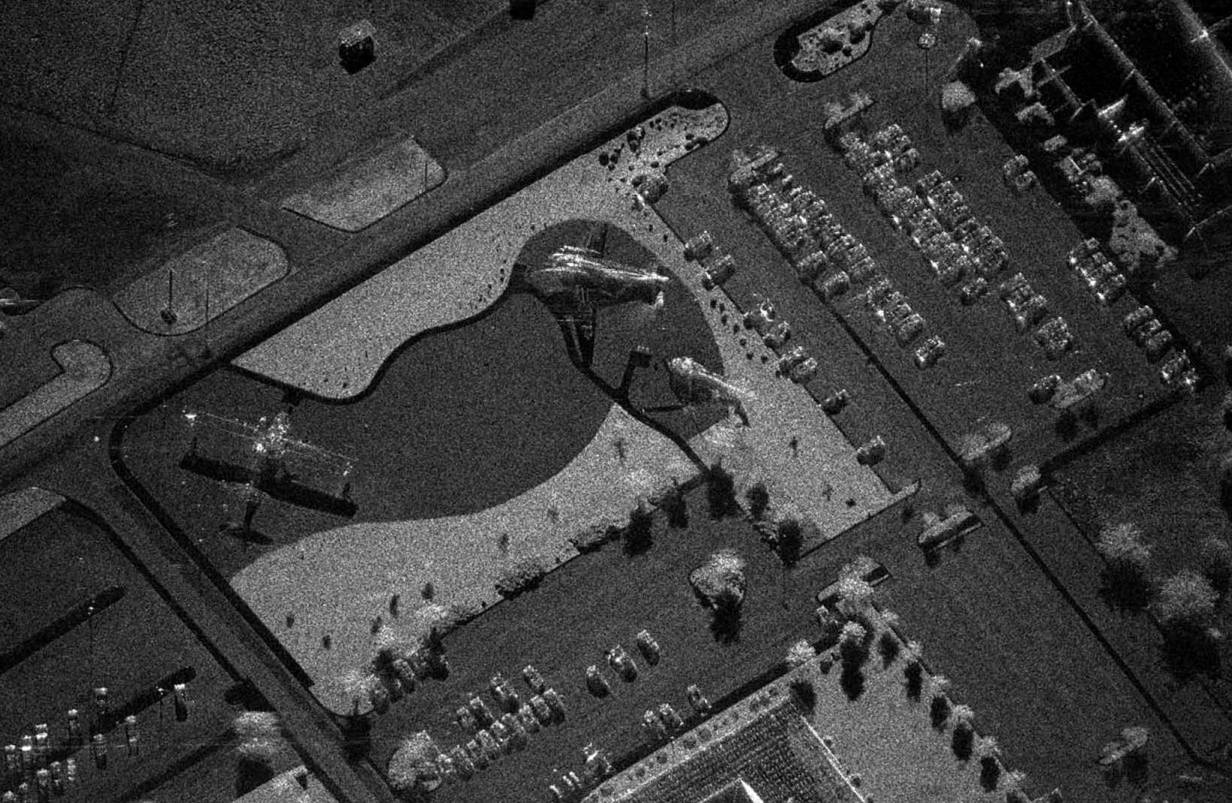

(803, 1232, 3)

In [2]:
import IPython

def imshow(img):
    returnValue, buffer = cv2.imencode('.jpg', img)
    IPython.display.display(IPython.display.Image(data=buffer.tobytes()))

imshow(img)

height, width, channels = img.shape
img.shape

In [3]:
import numpy as np
import time

def ps_filter(img):
    #Sobel Hor filter  
    kernelV    = np.array([[-1.0,-2.0,-1.0],[0.0,0.0,0.0],[1.0,2.0,1.0]],np.float32)
    kernelH    = np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]],np.float32)
    kernelG    = np.array([[1.0,2.0,1.0],[2.0,4.0,2.0],[1.0,2.0,1.0]],np.float32)
    kernelD   = np.ones((3,3),np.uint8)
    buf       = np.ones((height,width),np.uint8)
    frame_out = np.ones((height,width),np.uint8)

    num_frames    = 20

    gaussian_kernel = cv2.getGaussianKernel(5,3)
#     print(gaussian_kernel)
    # kernel_2D = gaussian_kernel @ gaussian_kernel.transpose()

    start = time.time()
    frame_in_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # cv2.filter2D(img, -1, kernelG, buf, borderType=cv2.BORDER_CONSTANT)
    blurred=cv2.filter2D(img, -1, gaussian_kernel)
    cv2.dilate(buf, kernelD, frame_out, borderType=cv2.BORDER_CONSTANT)
#     imshow(blurred)

    time_sw_total = time.time() - start
    print("Time Taken: {} ".format(time_sw_total))

In [5]:
import cv2 #NOTE: This needs to be loaded first

# Load filter2D + dilate overlay
from pynq import Overlay
bs = Overlay("/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2Filter2DDilate.bit")
bs.download()
import pynq_cv.overlays.xv2Filter2DDilate as xv2

# Load xlnk memory manager
from pynq import Xlnk
Xlnk.set_allocator_library('/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2Filter2DDilate.so')
mem_manager = Xlnk()

In [6]:
import numpy as np
import time
import multiprocessing
from multiprocessing.pool import ThreadPool

def stream_fpga_filter(img):
    kernelF    = np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]],np.float32)
    kernelVoid = np.zeros(0)
    xFin       = mem_manager.cma_array((height,width),np.uint8)
    xFbuf      = mem_manager.cma_array((height,width),np.uint8)
    xFout      = mem_manager.cma_array((height,width),np.uint8)

#     num_frames       = 20

#     xFin[:]    = frame_in_gray[:]
    start = time.time()
    for _ in range(10):
        frame_in_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        xFin[:]       = frame_in_gray[:]
        
        xv2.filter2D(xFin, -1, kernelF, xFbuf, borderType=cv2.BORDER_CONSTANT)
        xv2.dilate(xFbuf, kernelVoid, xFout, borderType=cv2.BORDER_CONSTANT)
        
#         frame_out[:]  = xFout[:]
#         imshow(xFout[:])
    time_hw_total = time.time() - start
    print("Time Taken:  " + str(time_hw_total))

def fpga_filter(img):
    kernelF    = np.array([[1.0,2.0,1.0],[0.0,0.0,0.0],[-1.0,-2.0,-1.0]],np.float32)
    kernelVoid = np.zeros(0)
    xFin       = mem_manager.cma_array((height,width),np.uint8)
    xFbuf      = mem_manager.cma_array((height,width),np.uint8)
    xFout      = mem_manager.cma_array((height,width),np.uint8)

#     num_frames       = 20

#     xFin[:]    = frame_in_gray[:]
    start = time.time()
    frame_in_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    xFin[:]       = frame_in_gray[:]

    xv2.filter2D(xFin, -1, kernelF, xFbuf, borderType=cv2.BORDER_CONSTANT)
    xv2.dilate(xFbuf, kernelVoid, xFout, borderType=cv2.BORDER_CONSTANT)

#         frame_out[:]  = xFout[:]
#         imshow(xFout[:])
    time_hw_total = time.time() - start
    print("Time Taken:  " + str(time_hw_total))

# Single Processing: 

In [10]:
print('time taken for big image')
num_iterations=10
print("Time taken on PS with Single Processing for {} Iterations".format(num_iterations))
start_time=time.time()
for i in range(num_iterations):
    ps_filter(img)
print('Time taken for non-parallel execution: {}'.format(time.time()-start_time))

num_iterations=10
print("Time taken on FPGA with stream Single Processing for {} Iterations".format(num_iterations))
start_time=time.time()
# for i in range(num_iterations):
stream_fpga_filter(img)
print('Time taken for non-parallel execution: {}'.format(time.time()-start_time))

print("Time taken on FPGA with stream Single Processing for {} Iterations".format(num_iterations))
start_time=time.time()
for i in range(num_iterations):
    fpga_filter(img)
print('Time taken for non-parallel execution: {}'.format(time.time()-start_time))


time taken for big image
Time taken on PS with Single Processing for 10 Iterations
Time Taken: 0.13269996643066406 
Time Taken: 0.13268327713012695 
Time Taken: 0.12970972061157227 
Time Taken: 0.13332390785217285 
Time Taken: 0.12870121002197266 
Time Taken: 0.13068842887878418 
Time Taken: 0.1296682357788086 
Time Taken: 0.13002347946166992 
Time Taken: 0.12903857231140137 
Time Taken: 0.13228154182434082 
Time taken for non-parallel execution: 1.3313708305358887
Time taken on FPGA with stream Single Processing for 10 Iterations
Time Taken:  0.12682604789733887
Time taken for non-parallel execution: 0.13327717781066895
Time taken on FPGA with stream Single Processing for 10 Iterations
Time Taken:  0.012662649154663086
Time Taken:  0.012566566467285156
Time Taken:  0.012731552124023438
Time Taken:  0.012692451477050781
Time Taken:  0.014182806015014648
Time Taken:  0.012612342834472656
Time Taken:  0.012599468231201172
Time Taken:  0.012584447860717773
Time Taken:  0.01253914833068847

# Multi-processing

In [11]:
print("Time taken on PS with Multi-Processing for {} Iterations".format(num_iterations))
pool=multiprocessing.Pool()
start_time=time.time()
pool.map(ps_filter, [img]*num_iterations)
print('Time taken for multi-processing= {}'.format(time.time()-start_time))


print("Time taken on FPGA with Multi-Processing for {} Iterations".format(num_iterations))
pool=multiprocessing.Pool()
start_time=time.time()
pool.map(fpga_filter, [img]*num_iterations)
print('Time taken for multi-processing= {}'.format(time.time()-start_time))

Time taken on PS with Multi-Processing for 10 Iterations
Time Taken: 0.14938759803771973 
Time Taken: 0.14613795280456543 
Time Taken: 0.17258191108703613 
Time Taken: 0.16041874885559082 
Time Taken: 0.1465895175933838 
Time Taken: 0.16458487510681152 
Time Taken: 0.18996834754943848 
Time Taken: 0.17488837242126465 
Time Taken: 0.1420900821685791 
Time Taken: 0.14748835563659668 
Time taken for multi-processing= 0.6147654056549072
Time taken on FPGA with Multi-Processing for 10 Iterations
Time Taken:  0.026592016220092773
Time Taken:  0.03455090522766113
Time Taken:  0.03878378868103027
Time Taken:  0.02924060821533203
Time Taken:  0.023592233657836914
Time Taken:  0.026427745819091797
Time Taken:  0.024094104766845703
Time Taken:  0.025920391082763672
Time Taken:  0.022583961486816406
Time Taken:  0.020882129669189453
Time taken for multi-processing= 0.33450984954833984
